In [15]:
import pandas as pd
import numpy as np
from prep_tools import columns_count
from tqdm import tqdm

In [23]:
cols = ['SUBJECT_ID', 'HADM_ID','ITEMID','CHARTTIME','VALUE','WARNING','ERROR','STOPPED'] #'STORETIME'
chunksize = 10**6
df_generator = pd.read_csv('../data/CHARTEVENTS.csv',chunksize = chunksize,usecols = cols,low_memory=False)
df = next(df_generator)
pu_df = pd.DataFrame(columns = df.columns)

In [24]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'WARNING',
       'ERROR', 'STOPPED'],
      dtype='object')

In [26]:
df

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,WARNING,ERROR,STOPPED
0,36,165660,223834,2134-05-12 12:00:00,15.00,0,0,NaN
1,36,165660,223835,2134-05-12 12:00:00,100.00,0,0,NaN
2,36,165660,224328,2134-05-12 12:00:00,0.37,0,0,NaN
3,36,165660,224329,2134-05-12 12:00:00,6.00,0,0,NaN
4,36,165660,224330,2134-05-12 12:00:00,2.50,0,0,NaN
...,...,...,...,...,...,...,...,...
999995,10694,138159,224697,2153-08-17 10:19:00,16.00,0,0,NaN
999996,10694,138159,224738,2153-08-17 10:19:00,0.70,0,0,NaN
999997,10694,138159,224828,2153-08-17 10:19:00,-1.00,0,0,NaN
999998,10694,138159,225698,2153-08-17 10:19:00,22.00,0,0,NaN


In [20]:
item_label_dict_complete = {227618: 'Pressure Ulcer Stage #9',
 227619: 'Pressure Ulcer Stage #10',
 224965: 'Pressure Ulcer Stage #2',
 224966: 'Pressure Ulcer Stage #3',
 224967: 'Pressure Ulcer Stage #4',
 224968: 'Pressure Ulcer Stage #5',
 224969: 'Pressure Ulcer Stage #6',
 224970: 'Pressure Ulcer Stage #7',
 224971: 'Pressure Ulcer Stage #8',
 224631: 'Pressure Ulcer Stage #1',
 551: 'Pressure Sore #1 [Stage]',
 552: 'Pressure Sore #2 [Stage]',
 553: 'Pressure Sore #3 [Stage]'}

In [27]:
pu_list = set(item_label_dict_complete.keys())
print(len(pu_list))

13


In [33]:
import time
df_generator = pd.read_csv('../data/CHARTEVENTS.csv',chunksize = chunksize,usecols = cols,low_memory=False)
count = 0
#t1 = time.time() #时间主要在读数据上，没有帮助
for df in tqdm(df_generator):
    tmp_pu_df = df.loc[df['ITEMID'].isin(pu_list)]
    pu_df = pd.concat([pu_df,tmp_pu_df])
    count += len(tmp_pu_df)
    #if count > 10:
        #break

331it [06:06,  1.11s/it]


In [35]:
pu_df.shape

(220756, 8)

In [36]:
pu_df.to_csv('pu_df.csv')
#pu_df = pd.read_csv('pu_df.csv')

In [37]:
pu_df.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,WARNING,ERROR,STOPPED
192689796,117,164853,551,2133-11-30 12:00:00,Through Dermis,NaN,NaN,NotStopd
192695631,145,198161,551,2144-04-23 10:00:00,"Red, Unbroken",NaN,NaN,NotStopd
192701417,117,164853,551,2133-11-30 04:00:00,Through Dermis,NaN,NaN,NotStopd
192710827,145,198161,551,2144-04-25 11:00:00,Through Dermis,NaN,NaN,NotStopd
192713385,145,198161,551,2144-04-25 23:00:00,Through Dermis,NaN,NaN,NotStopd


In [38]:
def columns_count(df,key):
    print(df[key].isna().sum() / len(df))
    if len(df[key].unique())<5:
        df[key].value_counts(normalize=True).plot(kind='bar',figsize=(6, 8));
    else:
        df[key].value_counts(normalize=True).plot(kind='barh',figsize=(10, 20));

0.0


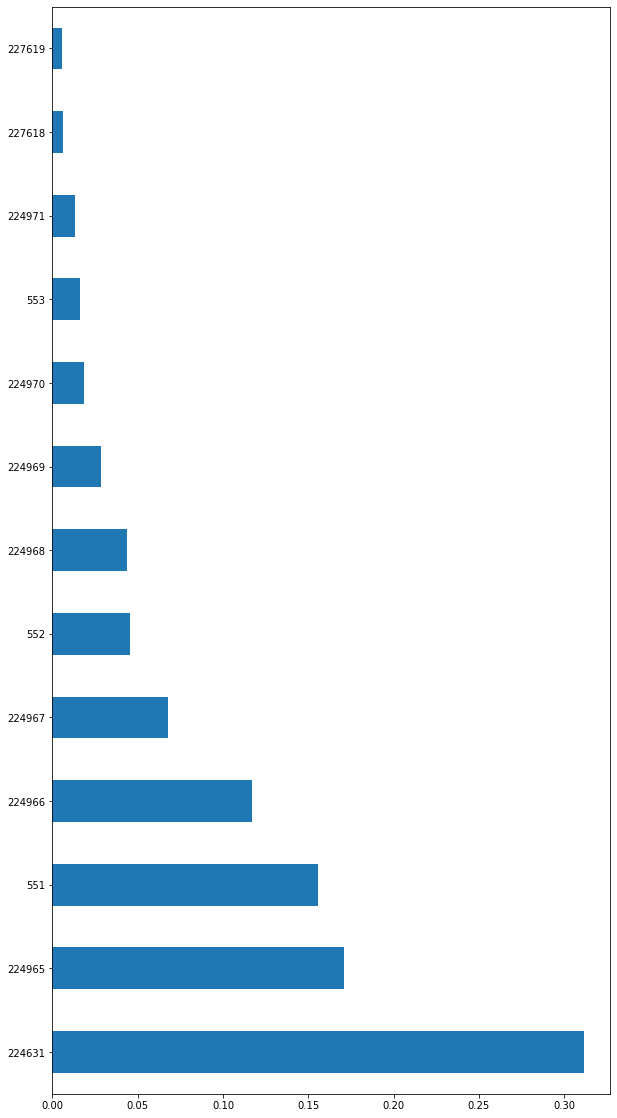

In [39]:
columns_count(pu_df,'ITEMID') #224631, 224965, 224966

In [47]:
#pu_df = pu_df[pu_df['ITEMID']!=551]

In [40]:
len(pu_df['HADM_ID'].unique())

6894

In [41]:
pu_df = pu_df.dropna(subset = ['VALUE'])

In [42]:
severe_pu = pu_df[-pu_df['VALUE'].isin(['Red, Unbroken','Red; unbroken','Intact,Color Chg'])]

In [43]:
severe_pu.shape

(163805, 8)

In [44]:
len(severe_pu['HADM_ID'].unique())

5304

In [90]:
timeline_df = pd.DataFrame(columns = ['ADM_ID','ADM_TIME','DIS_TIME','PU_TIME','PU_name'])
chart_pu_ids = severe_pu['HADM_ID'].unique()
adm_df = pd.read_csv('../data/ADMISSIONS.csv')

for adm_id in tqdm(chart_pu_ids):
    tmp_df = severe_pu[severe_pu['HADM_ID'] == adm_id]
    adm_row = adm_df[adm_df.HADM_ID == adm_id].iloc[0]
    event_id = list(tmp_df['ITEMID'])
    event_name = [item_label_dict_complete[x] for x in event_id]
    raw_date_list = list(tmp_df['CHARTTIME'])
    raw_date_list,event_name = zip(*sorted(zip(raw_date_list,event_name)))
    tmp_len = len(timeline_df)
    timeline_df.loc[tmp_len] = [adm_id,adm_row['ADMITTIME'],adm_row['DISCHTIME'],raw_date_list,event_name]
timeline_df = timeline_df.set_index('ADM_ID')

100%|██████████| 5304/5304 [01:05<00:00, 81.54it/s]


In [88]:
raw_date_list.sort()

In [89]:
raw_date_list

['2148-12-06 08:18:00', '2148-12-06 08:19:00', '2148-12-06 12:00:00']

In [91]:
timeline_df.PU_TIME[0]

('2133-11-25 12:00:00',
 '2133-11-25 12:00:00',
 '2133-11-29 05:30:00',
 '2133-11-29 05:30:00',
 '2133-11-30 00:00:00',
 '2133-11-30 00:00:00',
 '2133-11-30 04:00:00',
 '2133-11-30 04:00:00',
 '2133-11-30 12:00:00',
 '2133-11-30 12:00:00')

In [52]:
severe_pu.to_csv('severe_pu.csv')

In [72]:
timeline_df.PU_name

0       [Pressure Sore #1 [Stage], Pressure Sore #1 [S...
1       [Pressure Sore #1 [Stage], Pressure Sore #1 [S...
2       [Pressure Sore #1 [Stage], Pressure Sore #1 [S...
3       [Pressure Sore #1 [Stage], Pressure Sore #1 [S...
4       [Pressure Sore #1 [Stage], Pressure Sore #1 [S...
                              ...                        
5299                            [Pressure Ulcer Stage #1]
5300    [Pressure Ulcer Stage #2, Pressure Ulcer Stage...
5301    [Pressure Ulcer Stage #3, Pressure Ulcer Stage...
5302                            [Pressure Ulcer Stage #1]
5303    [Pressure Ulcer Stage #1, Pressure Ulcer Stage...
Name: PU_name, Length: 5304, dtype: object

In [100]:
timeline_df.head()

,ADM_TIME,DIS_TIME,PU_TIME,PU_name
ADM_ID,,,,
164853,2133-11-13 21:34:00,2133-12-01 17:00:00,"(2133-11-25 12:00:00, 2133-11-25 12:00:00, 213...","(Pressure Sore #1 [Stage], Pressure Sore #1 [S..."
198161,2144-03-29 01:44:00,2144-07-14 16:15:00,"(2144-04-23 15:00:00, 2144-04-23 15:00:00, 214...","(Pressure Sore #1 [Stage], Pressure Sore #1 [S..."
140037,2176-09-02 14:22:00,2176-09-25 13:15:00,"(2176-09-11 13:00:00, 2176-09-11 14:45:00, 217...","(Pressure Sore #1 [Stage], Pressure Sore #1 [S..."
199280,2120-12-31 07:15:00,2121-01-27 12:40:00,"(2121-01-20 08:00:00, 2121-01-20 12:00:00, 212...","(Pressure Sore #1 [Stage], Pressure Sore #1 [S..."
107880,2106-06-17 19:51:00,2106-06-24 17:50:00,"(2106-06-20 01:00:00, 2106-06-21 09:00:00, 210...","(Pressure Sore #1 [Stage], Pressure Sore #1 [S..."


In [106]:
timeline_df.to_csv('./result/pu_chart/timeline_df.csv')

In [105]:
aaa = pd.read_csv('timeline_df.csv')
aaa.head()

,ADM_ID,ADM_TIME,DIS_TIME,PU_TIME,PU_name
0,164853,2133-11-13 21:34:00,2133-12-01 17:00:00,"('2133-11-25 12:00:00', '2133-11-25 12:00:00',...","('Pressure Sore #1 [Stage]', 'Pressure Sore #1..."
1,198161,2144-03-29 01:44:00,2144-07-14 16:15:00,"('2144-04-23 15:00:00', '2144-04-23 15:00:00',...","('Pressure Sore #1 [Stage]', 'Pressure Sore #1..."
2,140037,2176-09-02 14:22:00,2176-09-25 13:15:00,"('2176-09-11 13:00:00', '2176-09-11 14:45:00',...","('Pressure Sore #1 [Stage]', 'Pressure Sore #1..."
3,199280,2120-12-31 07:15:00,2121-01-27 12:40:00,"('2121-01-20 08:00:00', '2121-01-20 12:00:00',...","('Pressure Sore #1 [Stage]', 'Pressure Sore #1..."
4,107880,2106-06-17 19:51:00,2106-06-24 17:50:00,"('2106-06-20 01:00:00', '2106-06-21 09:00:00',...","('Pressure Sore #1 [Stage]', 'Pressure Sore #1..."


In [77]:
import re
tmp_id = chart_pu_ids[100]
values = [int(re.search('\d',x).group()) for x in timeline_df.loc[tmp_id].PU_name]#timeline_dict[tmp_id][0]]

In [78]:
values

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

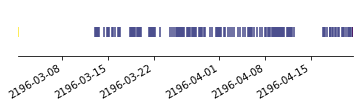

In [99]:
import matplotlib.pyplot as plt
tmp_id = chart_pu_ids[100]
values = [int(re.search('\d',x).group()) for x in timeline_df.loc[tmp_id].PU_name]
values.append(0)
values.insert(0,5)
#X = timeline_dict[tmp_id][1]
X = list(timeline_df.loc[tmp_id]['PU_TIME'])
X.append(timeline_df.loc[tmp_id]['DIS_TIME'])
X.insert(0,timeline_df.loc[tmp_id]['ADM_TIME'])
X= pd.to_datetime(X)
fig, ax = plt.subplots(figsize=(6,1))
ax.scatter(X, [1]*len(X), c=values,
           marker='|', s=100)

fig.autofmt_xdate()

# everything after this is turning off stuff that's plotted by default

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.get_yaxis().set_ticklabels([])
day = pd.to_timedelta("1")
plt.xlim(X[0] - day, X[-1] + day)
plt.show()

In [96]:
X

('2196-03-13 01:00:00',
 '2196-03-13 04:00:00',
 '2196-03-13 08:00:00',
 '2196-03-13 12:00:00',
 '2196-03-13 15:00:00',
 '2196-03-14 10:00:00',
 '2196-03-14 20:00:00',
 '2196-03-15 00:00:00',
 '2196-03-15 04:00:00',
 '2196-03-15 13:00:00',
 '2196-03-15 17:30:00',
 '2196-03-16 00:00:00',
 '2196-03-16 12:00:00',
 '2196-03-16 16:00:00',
 '2196-03-16 20:00:00',
 '2196-03-18 08:00:00',
 '2196-03-18 12:00:00',
 '2196-03-18 16:00:00',
 '2196-03-18 20:00:00',
 '2196-03-19 00:00:00',
 '2196-03-19 04:00:00',
 '2196-03-19 11:00:00',
 '2196-03-19 15:00:00',
 '2196-03-19 18:00:00',
 '2196-03-19 20:00:00',
 '2196-03-20 00:00:00',
 '2196-03-21 06:00:00',
 '2196-03-21 08:30:00',
 '2196-03-21 13:00:00',
 '2196-03-21 16:00:00',
 '2196-03-21 20:00:00',
 '2196-03-22 01:00:00',
 '2196-03-22 05:00:00',
 '2196-03-23 00:00:00',
 '2196-03-24 10:00:00',
 '2196-03-24 20:00:00',
 '2196-03-25 01:00:00',
 '2196-03-25 08:00:00',
 '2196-03-25 14:00:00',
 '2196-03-25 17:00:00',
 '2196-03-25 20:00:00',
 '2196-03-26 00:

In [59]:
adm_df = pd.read_csv('../data/ADMISSIONS.csv')
adm_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [63]:
aaa = [1,2,3,4,5]
aaa.insert(2,100)
print(aaa)

[1, 2, 100, 3, 4, 5]


In [65]:
for i in range(len(pu_adm_df)):
    row = pu_adm_df.iloc[i]
    tmp_id = row['HADM_ID']
    timeline_dict[tmp_id][0].insert(0,'admission_0')
    timeline_dict[tmp_id][0].append('discharge_1')
    timeline_dict[tmp_id][1].insert(0,pd.to_datetime(row['HADM_ID']).date())
    timeline_dict[tmp_id][1].append(pd.to_datetime(row['DISCHTIME']).date())

In [61]:
len(pu_adm_df)

3196

In [20]:
item_df = pd.read_csv('../data/D_ITEMS.csv')

In [25]:
df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME',
       'STORETIME', 'CGID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'WARNING',
       'ERROR', 'RESULTSTATUS', 'STOPPED'],
      dtype='object')

In [28]:
count = 0
for i in range(len(df)):
    row = df.iloc[i]
    time_diff = abs(pd.to_datetime(row['CHARTTIME']).date() - pd.to_datetime(row['STORETIME']).date())
    if time_diff > pd.Timedelta('1 days'):
        count +=1
print(count / len(df))

0.00015


In [29]:
item_df.columns

Index(['ROW_ID', 'ITEMID', 'LABEL', 'ABBREVIATION', 'DBSOURCE', 'LINKSTO',
       'CATEGORY', 'UNITNAME', 'PARAM_TYPE', 'CONCEPTID'],
      dtype='object')

In [23]:
print(item_df.shape)
item_df = item_df.dropna(subset = ['LABEL'])
print(item_df.shape)

(12487, 10)
(12483, 10)


In [24]:
pu_item = item_df.loc[item_df['LABEL'].str.lower().str.contains('pressure ulcer stage')]

In [25]:
pu_item

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
10819,14963,227618,Pressure Ulcer Stage #9,Pressure Ulcer Stage #9,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
10820,14964,227619,Pressure Ulcer Stage #10,Pressure Ulcer Stage #10,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
10989,13482,224965,Pressure Ulcer Stage #2,Pressure Ulcer Stage #2,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
10990,13483,224966,Pressure Ulcer Stage #3,Pressure Ulcer Stage #3,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
10991,13484,224967,Pressure Ulcer Stage #4,Pressure Ulcer Stage #4,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
10992,13485,224968,Pressure Ulcer Stage #5,Pressure Ulcer Stage #5,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
10993,13486,224969,Pressure Ulcer Stage #6,Pressure Ulcer Stage #6,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
10994,13487,224970,Pressure Ulcer Stage #7,Pressure Ulcer Stage #7,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
10995,13488,224971,Pressure Ulcer Stage #8,Pressure Ulcer Stage #8,metavision,chartevents,Skin - Impairment,NaN,Text,NaN
11316,13417,224631,Pressure Ulcer Stage #1,Pressure Ulcer Stage #1,metavision,chartevents,Skin - Impairment,NaN,Text,NaN


In [26]:
metavision_list = list(pu_item['ITEMID'])

In [27]:
metavision_list = [x for x in metavision_list if x != 224631]

In [38]:
item_label_dict = {}
for i in range(len(pu_item)):
    row = pu_item.iloc[i]
    if row['ITEMID'] in metavision_list:
        item_label_dict[row['ITEMID']] = row['LABEL'].str()

AttributeError: 'str' object has no attribute 'str'

In [31]:
item_label_dict

{227618: 'Pressure Ulcer Stage #9',
 227619: 'Pressure Ulcer Stage #10',
 224965: 'Pressure Ulcer Stage #2',
 224966: 'Pressure Ulcer Stage #3',
 224967: 'Pressure Ulcer Stage #4',
 224968: 'Pressure Ulcer Stage #5',
 224969: 'Pressure Ulcer Stage #6',
 224970: 'Pressure Ulcer Stage #7',
 224971: 'Pressure Ulcer Stage #8'}

In [32]:
item_label_dict[552] = 'Pressure Sore #2 [Stage]'
item_label_dict[553] = 'Pressure Sore #3 [Stage]'

In [33]:
item_label_dict

{227618: 'Pressure Ulcer Stage #9',
 227619: 'Pressure Ulcer Stage #10',
 224965: 'Pressure Ulcer Stage #2',
 224966: 'Pressure Ulcer Stage #3',
 224967: 'Pressure Ulcer Stage #4',
 224968: 'Pressure Ulcer Stage #5',
 224969: 'Pressure Ulcer Stage #6',
 224970: 'Pressure Ulcer Stage #7',
 224971: 'Pressure Ulcer Stage #8',
 552: 'Pressure Sore #2 [Stage]',
 553: 'Pressure Sore #3 [Stage]'}

In [39]:
import json
json.dump(item_label_dict,open('item_label_dict.json','w'))

In [45]:
care_list = [551,552,553]

In [46]:
metavision_list.extend(care_list)
pu_item_list = metavision_list

In [47]:
pu_item_list

[227618,
 227619,
 224965,
 224966,
 224967,
 224968,
 224969,
 224970,
 224971,
 551,
 552,
 553]

In [11]:
item_df['CATEGORY'].value_counts()

Free Form Intake            2420
Access Lines - Invasive      312
ORGANISM                     312
Skin - Impairment            271
Labs                         148
                            ... 
NG Feeding                     1
Research Enrollment Note       1
Meds                           1
Quick Admit                    1
VBG'S                          1
Name: CATEGORY, Length: 94, dtype: int64

In [12]:
item_df['CATEGORY'].isna().sum()

6438

In [13]:
2420 / 12487

0.1938015536157604

In [ ]:
from collections import defaultdict
chart_pu_ids = pu_df['HADM_ID'].unique()
timeline_dict = defaultdict(lambda:[[],[]])
for adm_id in chart_pu_ids:
    tmp_df = pu_df[pu_df['HADM_ID'] == adm_id]
    event_id = list(tmp_df['ITEMID'])
    event_name = [item_label_dict[x] for x in event_id]
    raw_date_list = tmp_df['CHARTTIME']
    date_list = [pd.to_datetime(x).date() for x in raw_date_list]
    timeline_dict[adm_id][0] = event_name
    timeline_dict[adm_id][1] = date_list

In [ ]:
adm_df = pd.read_csv('../data/ADMISSIONS.csv')
for i in range(len(pu_adm_df)):
    row = pu_adm_df.iloc[i]
    tmp_id = row['HADM_ID']
    timeline_dict[tmp_id][0].insert(0,'admission_0')
    timeline_dict[tmp_id][0].append('discharge_1')
    timeline_dict[tmp_id][1].insert(0,pd.to_datetime(row['ADMITTIME']).date())
    timeline_dict[tmp_id][1].append(pd.to_datetime(row['DISCHTIME']).date())